c:\Users\liao\PycharmProjects\pythonProject1\AAA.Graduate work\Fittng_lastversion\mrk304#6\../..\sagan\stellar_continuum.py:43: RuntimeWarning: invalid value encountered in log
  logf_star_A0V = np.interp(logw_even_kpa, logw_star, np.log(flux_A0V))


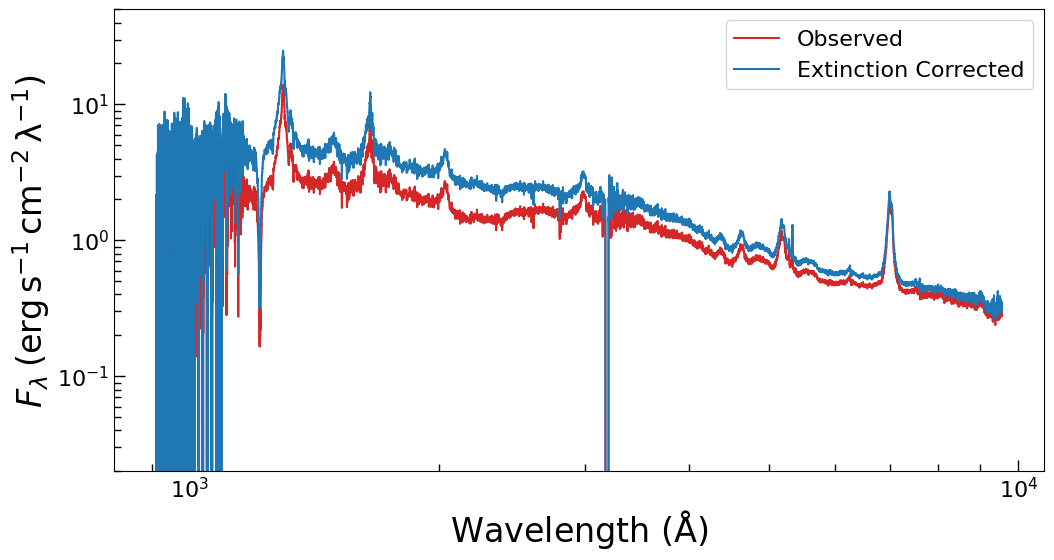

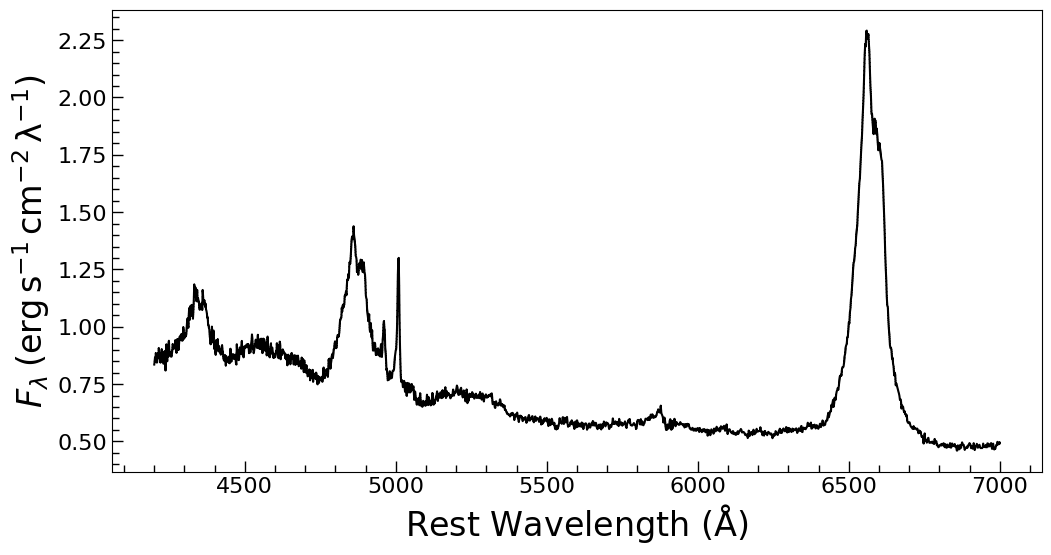

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from astropy.modeling import models, fitting
import sys
sys.path.append("../..")
import sagan

import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

ls_km = 2.99792e5 # km/s

datapath = 'data'
hdul = fits.open('mrk304sed.fit')#---------------------------修改文件名
header = hdul[0].header
flux = hdul[0].data * 1e14

w0 = header['CRVAL1']
dw = header['CD1_1']
wave = w0 + dw*np.arange(flux.size)

# Find the V band attenuation from https://ned.ipac.caltech.edu/ -- FOREGROUND GALACTIC EXTINCTION
from extinction import ccm89, remove

A_V = 0.2    #------------------------------修改 消光系数
flux_dred = remove(ccm89(wave, A_V, r_v=3.1, unit='aa'), flux)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(wave, flux, label='Observed', c='C3')
ax.step(wave, flux_dred, label='Extinction Corrected', c='C0')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.legend(fontsize=16)
ax.set_ylim(0.02, 50)#-------------------------------修改y可见范围
ax.minorticks_on()
plt.show()

zred = 0.0657 #-------------------------------------修改红移

fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 4200, 7000
wave_rst = wave / (1 + zred)
fltr = (wave_rst > wmin) & (wave_rst < wmax)
wave_use = wave_rst[fltr]
flux_use = flux_dred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()

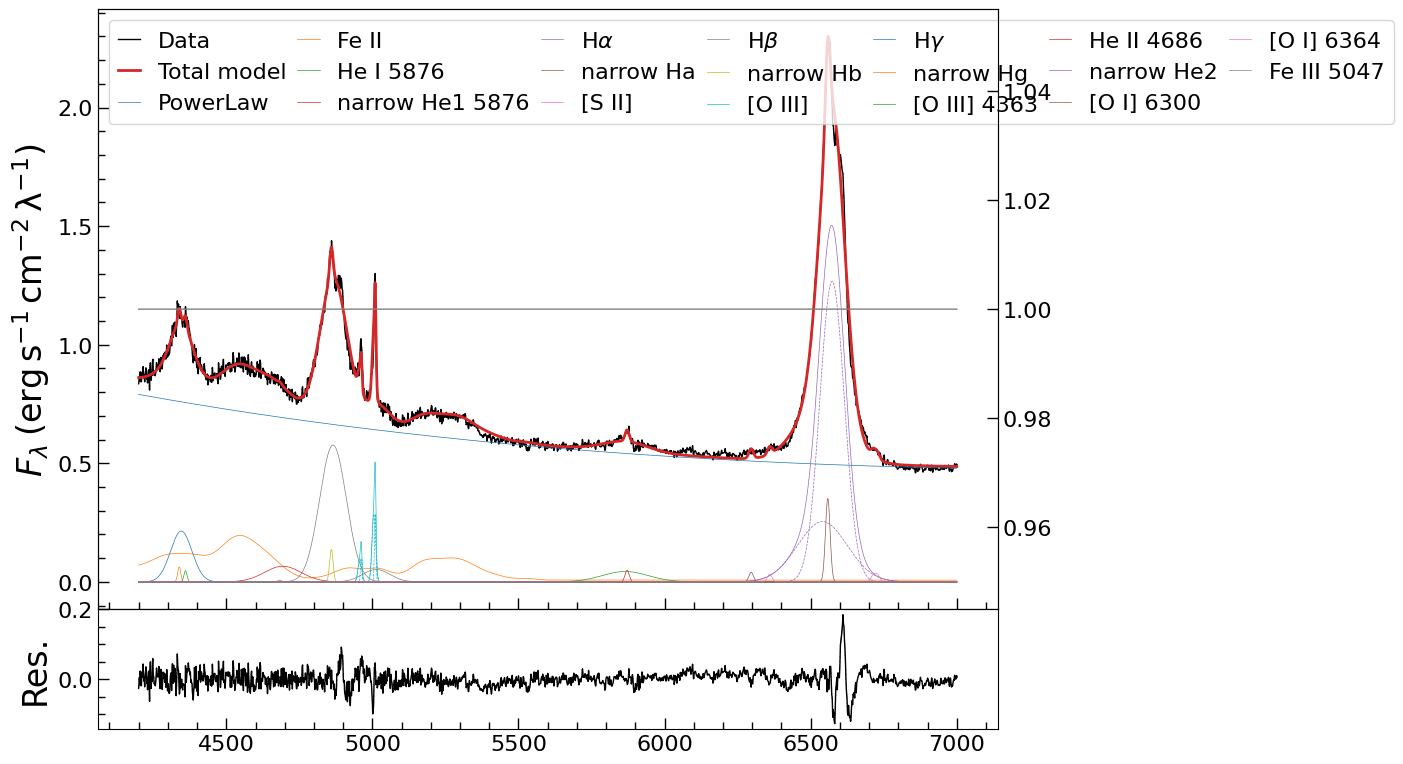

<PowerLaw1D(amplitude=0.77659789, x_0=6100., alpha=0.41449554, name='PowerLaw')>
<IronTemplate(amplitude=0.36756004, stddev=3089.55, z=0., name='Fe II')>
<Line_MultiGauss(amp_c=0.06383466, dv_c=-500., sigma_c=4000., wavec=5875.624, name='He I 5876')>
<Line_Gaussian(amplitude=0.07086015, dv=-200.37493092, sigma=363.99638452, wavec=5875.624, name='narrow He1 5876')>
<Line_MultiGauss(amp_c=1.93030464, dv_c=478.22441101, sigma_c=1918.48690929, wavec=6562.819, amp_w0=0.20010804, dv_w0=-1502.15179746, sigma_w0=3881.70736159, name='H$\\alpha$')>
<Line_Gaussian(amplitude=0.53530892, dv=-200.37493092, sigma=363.99638452, wavec=6562.819, name='narrow Ha')>
<Line_MultiGauss_doublet(amp_c0=0.04025425, amp_c1=0.04231186, dv_c=-200.37493092, sigma_c=363.99638452, wavec0=6718.29, wavec1=6732.68, name='[S II]')>
<Line_MultiGauss(amp_c=0.74129515, dv_c=171.93398821, sigma_c=2824.16176904, wavec=4862.721, name='H$\\beta$')>
<Line_Gaussian(amplitude=0.17552265, dv=-200.37493092, sigma=363.99638452, wavec

In [11]:
poly = models.Polynomial1D(degree=2, name='multi')  # The name must be `multi`; no more than 5th order
#------------------------------------------------------------具体拟合，修改各成分
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict
pl = models.PowerLaw1D(amplitude=0.77659789, x_0=6100, alpha=0.41449554, fixed={'x_0': True,'amplitude':True,'alpha':True},name='PowerLaw')#---------------------------------修改PL
iron = sagan.IronTemplate(amplitude=0.36756004, stddev=3089.55, z=0, name='Fe II',fixed={'amplitude':True,'stddev':True})#---------------------------------修改FeII

bounds = {'sigma_w0': (100, 4000)}
b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=1.24, dv_c=460, sigma_c=1900, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.2, dv_w0=-1200, sigma_w0=3600)
b_hb = sagan.Line_MultiGauss(n_components=1, amp_c=0.55, dv_c=300, sigma_c=2600, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'])
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.3, dv_c=380, sigma_c=2200, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])

bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}

b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.027, dv_c=-900, sigma_c=3100, wavec=5875.624, name='He I 5876',bounds=bounds)
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.048, amp_c1=0.02,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')
line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=0.27, amp_c1=0.17, dv_c=-150, sigma_c=590, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=1, dv_w0=200, sigma_w0=150)
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.05, dv_c=-500, sigma_c=3500, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=1, amp_c1=0.4, dv_c=10, sigma_c=100,
                                        wavec0=wave_dict['NII_6583'], wavec1=wave_dict['NII_6548'], name='[N II]')

n_he1_5876 = sagan.Line_Gaussian(amplitude=0.05, wavec=5875.624, name=f'narrow He1 5876')
n_ha = sagan.Line_Gaussian(amplitude=0.34, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_hb = sagan.Line_Gaussian(amplitude=0.13, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_hg = sagan.Line_Gaussian(amplitude=0.1, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.1, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')
n_he2 = sagan.Line_Gaussian(amplitude=0.07, wavec=wave_dict['HeII_4686'], name=f'narrow He2')

n_o1_6300 = sagan.Line_Gaussian(amplitude=0.045, wavec=wave_dict['OI_6300'], name=f'[O I] 6300')
n_o1_6364 = sagan.Line_Gaussian(amplitude=0.025, wavec=wave_dict['OI_6364'], name=f'[O I] 6364')
n_fe10_6375 = sagan.Line_Gaussian(amplitude=0.017, wavec=wave_dict['FeX_6375'], name=f'[Fe X] 6375')

n_n3_4510 = sagan.Line_Gaussian(amplitude=0.03, wavec=wave_dict['NIII_4510'], name=f'[N III] 4510')
b_fe3_5047= sagan.Line_MultiGauss(n_components=1, amp_c=0.05, dv_c=-50, sigma_c=100, wavec=5047, name='Fe III 5047')#---------mark
b_he1_5016= sagan.Line_MultiGauss(n_components=1, amp_c=0.05, dv_c=-250, sigma_c=600, wavec=5016, name='He I 5016')#----

n_fe6_5146 = sagan.Line_Gaussian(amplitude=0.1, wavec=wave_dict['FeVI_5146'], name=f'[Fe VI] 5146')
n_n1_5200 = sagan.Line_Gaussian(amplitude=0.1, wavec=wave_dict['NI_5200'], name=f'[N I] 5200')


line_he1 =  b_he1+n_he1_5876
line_ha  =  b_ha + n_ha
line_hb  =  b_hb + n_hb
line_hg  =  b_hg + n_hg
line_he2 =  b_he2 + n_he2

m_init = (pl+iron+line_he1+line_ha+line_s2+line_hb +line_o3 +line_hg+n_o3_4363 +line_he2+n_o1_6300+n_o1_6364+b_fe3_5047 )*poly
#+line_he1+line_ha+line_s2+line_hb +line_o3 +line_hg+n_o3_4363 +line_he2+n_o1_6300+n_o1_6364+b_fe3_5047


# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

def tie_n2(model):
    return model['[N II]'].amp_c0 / 2.96
line_n2.amp_c1.tied = tie_n2

# Tie
def tie_narrow_sigma(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv(model):
    return model['[O III]'].dv_c

line_s2.sigma_c.tied = tie_narrow_sigma
line_s2.dv_c.tied = tie_narrow_dv
line_n2.sigma_c.tied = tie_narrow_sigma
line_n2.dv_c.tied = tie_narrow_dv

for line in [n_ha, n_hb, n_hg, n_he2, n_o3_4363,n_he1_5876,n_o1_6300,n_o1_6364,n_fe10_6375,n_n3_4510]:
    line.sigma.tied = tie_narrow_sigma
    line.dv.tied = tie_narrow_dv

fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
fltr1 = (wave_use > 4867) & (wave_use < 4905)
fltr2 = (wave_use > 6569) & (wave_use < 6616)
#fltr3 = (wave_use > 4200) & (wave_use < 4739)
fltr4 = (wave_use > 5018) & (wave_use < 5075)
#fltr5 = (wave_use > 6250) & (wave_use < 6794)
fltr11= (wave_use > 4260) & (wave_use < 4430)
fltr12= (wave_use > 4600) & (wave_use < 5080)
fltr13= (wave_use > 5550) & (wave_use < 6050)
fltr14= (wave_use > 6200) & (wave_use < 6890)

#weights[fltr1] = 0.0
#weights[fltr2] = 0.0
#weights[fltr3] = 0.0
#weights[fltr4] = 0.0
#weights[fltr5] = 0.0
#weights[fltr11] = 0.0
#weights[fltr12] = 0.0
#weights[fltr13] = 0.0
#weights[fltr14] = 0.0
m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
plt.show()

for m in m_fit:
    print(m.__repr__())